In [1]:
import sys
sys.path.append('../src')
from data import get_cleaned_dataframes
from models import ttl_word2vec, classification, get_word2vec_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: de_core_news_sm


load the preprocessed texts in all languages into a dataframe

In [2]:
cleaned_dataframe = get_cleaned_dataframes()

Split data into train and test sets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_dataframe['cleaned_paragraphs'], cleaned_dataframe['label'] , test_size=0.3)

## Word2Vec
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [4]:
from gensim.models import Word2Vec
model = get_word2vec_model(X_train, text_type="cleaned_paragraphs")

Top2Vec model not found.
Training new model on 181 documents.
Saving model.
Model:  /home/Bachelor-Thesis/models/classification/Word2Vec_de_cleaned_paragraphs  loaded


## Text Classification on manually trained Word2Vec model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.
- Method 1: averaging word vectors for each text

In [5]:
X_train_vect = classification.text2vec(X_train, model.wv)
X_test_vect = classification.text2vec(X_test, model.wv)

In [6]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

Instantiate and fit a basic Random Forest model on top of the vectors

In [7]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.86      0.92        78
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.86        78
   macro avg       0.50      0.43      0.46        78
weighted avg       1.00      0.86      0.92        78

classes in y_pred: {0, 1} classes in y_test: {0}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.86      0.92        78
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.86        78
   macro avg       0.50      0.43      0.46        78
weighted avg       1.00      

<AxesSubplot: ylabel='label'>

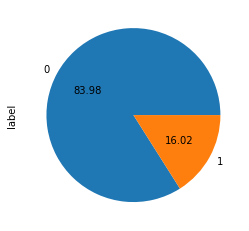

In [8]:
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [9]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

<AxesSubplot: ylabel='label'>

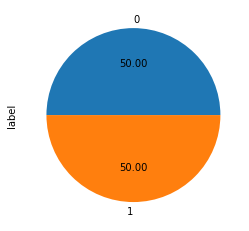

In [10]:
y_res.value_counts()
y_res.value_counts().plot.pie(autopct='%0.2f')

In [11]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, model.wv)
X_res_vect_avg = classification.average_vector(X_res_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correclty classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurence of given class in dataset

In [12]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.94      0.85      0.89        74
    begnadet       0.00      0.00      0.00         4

    accuracy                           0.81        78
   macro avg       0.47      0.43      0.45        78
weighted avg       0.89      0.81      0.85        78

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.76      0.85      0.80        60
    begnadet       0.18      0.11      0.14        18

    accuracy                           0.68        78
   macro avg       0.47      0.48      0.47        78
weighted avg       0.63   